In [1]:
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import nltk

import warnings
warnings.filterwarnings('ignore')

import gc

from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [2]:
df = pd.read_csv('/Users/may/Desktop/Applied/Walmart Bootcamp/Capstone Project/Data/data.csv')

In [3]:
df = df.dropna(subset=['category_1'])

In [4]:
df = df[['product_name', 'manufacturer', 'description','category_1']]
df.head()

,product_name,manufacturer,description,category_1
0,Hornby 2014 Catalogue,Hornby,Product Description Hornby 2014 Catalogue Box ...,Hobbies
1,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,Size Name:Large FunkyBuys® Large Christmas Hol...,Hobbies
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Hobbies
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Hobbies
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,Product Description Hornby RailRoad 0-4-0 Gild...,Hobbies


In [5]:
# Impute missing values
def fill_missing_value(data):
    data['product_name'].fillna(value = 'Unknown', inplace=True)
    data['manufacturer'].fillna(value = 'Unknown', inplace=True)
    data['description'].fillna(value = 'No description yet', inplace=True)
    return data

In [6]:
df = fill_missing_value(df)

In [7]:
df.isnull().sum()

product_name    0
manufacturer    0
description     0
category_1      0
dtype: int64

# Data preprocessing

In [8]:
from string import punctuation
import string
from pandas.core.groupby.generic import DataFrame

# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))

# nltk.download('stopwords')

# List of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Function to lowercase the words
def to_lower(x):
    return x.lower()

# Pipeline

In [9]:
from sklearn.preprocessing import FunctionTransformer

def text_transform(df):
    df['description'] = df['description'].apply(porter.stem)
    df['description'] = df['description'].apply(remove_punctuation)
    df['description'] = df['description'].apply(remove_stop_words)
    df['description'] = df['description'].apply(to_lower)
    return df

In [10]:
TextProcessor_1 = Pipeline(steps=[
    ('clean', FunctionTransformer(text_transform)),
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

TextProcessor_2 = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

cat_transformer = Pipeline(steps=[
    ('one-hot', OneHotEncoder())
])
preprocessor = ColumnTransformer(transformers=[
    ('text_1', TextProcessor_1, ['description']),
    ('text_2', TextProcessor_2, ['product_name']),
    ('one-hot', cat_transformer, ['manufacturer'])
])


In [11]:
X = df[['product_name', 'manufacturer', 'description']]
y = df[ 'category_1']

In [12]:
X = preprocessor.fit_transform(X)

In [13]:
import dill as pickle
with open('preprocessor_cat.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# Models

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6982, 3844)
Test df shape: (2328, 3844)


## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, classification_report
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.854381443298969
                                  precision    recall  f1-score   support

                   Arts & Crafts       0.80      0.91      0.85       188
             Baby & Toddler Toys       0.85      0.33      0.48        33
             Characters & Brands       0.90      0.81      0.85       263
                Cooking & Dining       0.00      0.00      0.00         2
         Die-Cast & Toy Vehicles       0.91      0.91      0.91       286
             Dolls & Accessories       0.93      0.86      0.90        94
                     Fancy Dress       0.92      0.87      0.90       149
              Figures & Playsets       0.79      0.87      0.83       303
                           Games       0.86      0.89      0.88       251
                       Gardening       0.00      0.00      0.00         1
                         Hobbies       0.77      0.87      0.82       340
                Home Accessories       0.00      0.00      0.00         1
          

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True,
                    max_depth=70,
                    max_features='auto',
                    min_samples_leaf= 4,
                    min_samples_split= 10,
                    n_estimators= 400)
rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score, classification_report
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.6756872852233677
                                  precision    recall  f1-score   support

                   Arts & Crafts       0.84      0.74      0.79       188
             Baby & Toddler Toys       0.00      0.00      0.00        33
             Characters & Brands       0.92      0.30      0.45       263
                Cooking & Dining       0.00      0.00      0.00         2
         Die-Cast & Toy Vehicles       0.79      0.84      0.81       286
             Dolls & Accessories       0.90      0.56      0.69        94
                     Fancy Dress       0.90      0.79      0.84       149
              Figures & Playsets       0.65      0.67      0.66       303
                           Games       0.79      0.80      0.79       251
                       Gardening       0.00      0.00      0.00         1
                         Hobbies       0.40      0.81      0.54       340
                Home Accessories       0.00      0.00      0.00         1
         

In [41]:
import dill as pickle
with open('model_log.pkl', 'wb') as file:
    pickle.dump(model_log, file)

# LSTM

In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

2023-01-12 15:39:55.812739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
df = df[['description', 'category_1']]

In [44]:
df.dropna(inplace=True)

In [45]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['description'] = df['description'].apply(clean_text)

In [46]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35522 unique tokens.


In [47]:
X = tokenizer.texts_to_sequences(df['description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9310, 250)


In [48]:
y = pd.get_dummies(df['category_1']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9310, 43)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6982, 250) (6982, 43)
(2328, 250) (2328, 43)


In [54]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 43)                1419      
                                                                 
Total params: 5,122,795
Trainable params: 5,122,795
Non-trainable params: 0
____________________________________________

In [55]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
99/99 [==============================] - 313s 3s/step - loss: 2.7712 - accuracy: 0.1326 - val_loss: 2.4837 - val_accuracy: 0.1416
Epoch 2/5
99/99 [==============================] - 202s 2s/step - loss: 2.1786 - accuracy: 0.2765 - val_loss: 1.9115 - val_accuracy: 0.3634
Epoch 3/5
99/99 [==============================] - 197s 2s/step - loss: 1.4331 - accuracy: 0.5466 - val_loss: 1.5516 - val_accuracy: 0.5308
Epoch 4/5
99/99 [==============================] - 186s 2s/step - loss: 1.0145 - accuracy: 0.7027 - val_loss: 1.4974 - val_accuracy: 0.5780
Epoch 5/5
99/99 [==============================] - 140s 1s/step - loss: 0.7545 - accuracy: 0.7956 - val_loss: 1.6458 - val_accuracy: 0.5780


In [56]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

73/73 [==============================] - 8s 103ms/step - loss: 1.5106 - accuracy: 0.6022
Test set
  Loss: 1.511
  Accuracy: 0.602


# feature importance

In [66]:
from string import punctuation

# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))

# List of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

import string

# Function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Function to lowercase the words
def to_lower(x):
    return x.lower()

In [67]:
from pandas.core.groupby.generic import DataFrame
# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
df['description'] = df['description'].apply(porter.stem)

df['description'] = df['description'].apply(remove_punctuation)
df['description'] = df['description'].apply(remove_stop_words)
df['description'] = df['description'].apply(to_lower)

df['product_name'] = df['product_name'].apply(remove_punctuation)
df['product_name'] = df['product_name'].apply(remove_stop_words)
df['product_name'] = df['product_name'].apply(to_lower)

In [12]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df['description'])
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (9310, 55000)


In [68]:
# Perform a TFIDF Transformation of the item product name with the top 55000 features and has an n-gram range of 1-2
tv2 = TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english')
X_product_name = tv2.fit_transform(df['product_name'])
print("Item product_name Shape: " + str(X_product_name.shape))

Item product_name Shape: (9310, 700)


In [14]:
X_dummies = (pd.get_dummies(df[['manufacturer']], sparse=True))
X_manufacturer = X_dummies.values
print("manufacturer Shape: " + str(X_manufacturer.shape))

manufacturer Shape: (9310, 2444)


In [69]:
# Combine everything together using Sparse matrix
X = hstack((X_product_name, X_manufacturer, X_description))

print(X.shape)

(9310, 58144)


In [70]:
feature1 = tv2.get_feature_names()
feature2 = list(X_dummies.columns)
feature3 = tv.get_feature_names()
feature = feature1+feature2+feature3

In [71]:
y = df['category_1']

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [78]:
print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6982, 58144)
Test df shape: (2328, 58144)


In [79]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [80]:
from sklearn.metrics import accuracy_score, classification_report
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.8612542955326461
                                  precision    recall  f1-score   support

                   Arts & Crafts       0.81      0.91      0.86       188
             Baby & Toddler Toys       0.85      0.33      0.48        33
             Characters & Brands       0.90      0.83      0.87       263
                Cooking & Dining       0.00      0.00      0.00         2
         Die-Cast & Toy Vehicles       0.91      0.92      0.92       286
             Dolls & Accessories       0.92      0.88      0.90        94
                     Fancy Dress       0.94      0.87      0.90       149
              Figures & Playsets       0.81      0.89      0.85       303
                           Games       0.85      0.88      0.86       251
                       Gardening       0.00      0.00      0.00         1
                         Hobbies       0.79      0.88      0.83       340
                Home Accessories       0.00      0.00      0.00         1
         

In [82]:
explainer = shap.LinearExplainer(model_log, X_train, feature_dependence="independent")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


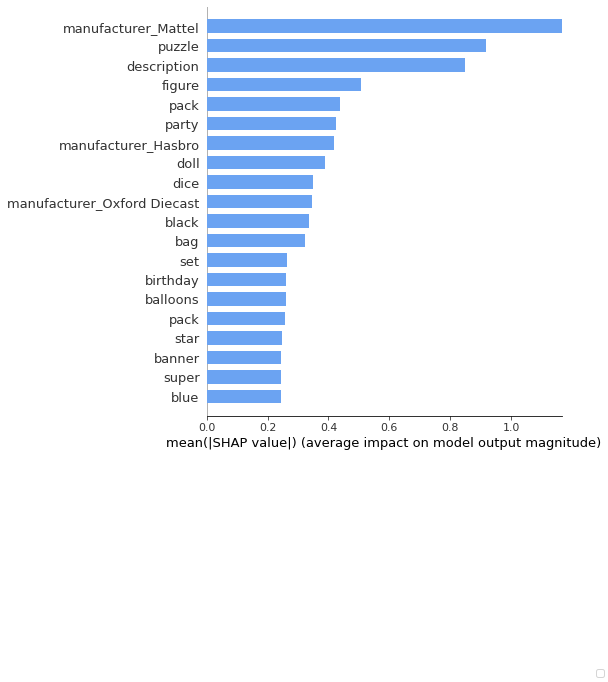

In [161]:
fig, ax = plt.subplots(1,1)
fig.legend(loc='lower right')
p= shap.summary_plot(shap_vals, feature_names=feature, color = cmap, class_names=model_log.classes_,plot_type="bar", show=False, color_bar_label=None, color_bar=False)
ax.get_legend().remove()
fig.show()